# Hyperparameter optimization with Population-based Training 

In this demo we will use Population-based training (PBT) to optimize the learning rate and weight decay for fine-tuning our classifier based on SageMakerTune.

**Note**: This notebook runs all training jobs locally. In order for it to work smoothly, you need to:

* Run on a instance with (at least) 4 GPUs, such as for example *ml.g4dn.12xlarge*
* Pick a kernel with PyTorch installed, such as for example *conda_pytorch_p36*

In [1]:
import logging
logging.getLogger().setLevel(logging.INFO)

## Install SageMakerTune

First we need to install SagemakerTune

In [2]:
%cd /home/ec2-user/SageMaker/sagemakertune/
! pip install --upgrade pip
! pip install -e .[gpsearchers]
%cd examples/hugging_face_example/

/home/ec2-user/SageMaker/sagemakertune
Obtaining file:///home/ec2-user/SageMaker/sagemakertune
  Preparing metadata (setup.py) ... done
  Attempting uninstall: sagemaker-tune
    Found existing installation: sagemaker-tune 0.1
    Uninstalling sagemaker-tune-0.1:
      Successfully uninstalled sagemaker-tune-0.1
  Running setup.py develop for sagemaker-tune
/home/ec2-user/SageMaker/sagemakertune/examples/hugging_face_example


## Install Dependencies

In [3]:
!pip install "transformers==4.6.1" "datasets[s3]==1.6.2" --upgrade

### Defining Optimization Parameters

In [1]:
# Specifies the maximum number of parallel workers to evaluate hyperparameter configurations. Training jobs of different
# workers are executed as subprocesses (we are using the "local" back-end). This means you should choose the number of
# workers to be no larger than the number of GPUs on the instance.
# If you like to use more workers or run on smaller GPU instances, you should use the "sagemaker" back-end, which
# however comes with larger overheads for starting and stopping a training job.
n_workers = 4

# The size of the population that PBT maintains
population_size = 8

# Specifies whether we maximize or minimize our metric
mode = 'max'

# The metric we aim to optimize. Needs to match the key name reported in your training script
metric = 'accuracy'

# PBT assignes more resources to better performing models. This parameters defines the resources that we want to use
resource_attr = 'iteration'

# The maximum amount of resources we can assign to any model.
max_iterations = 73 # corresponds to 3 epochs

## Defining Configuration Space

Here we define the domain for each hyperparameter we want to optimize

In [7]:
from sagemaker_tune.search_space import loguniform

config_space = {
    'learning_rate': loguniform(1e-6, 1e-4),
    'weight_decay': loguniform(1e-6, 1e-4)
}

If we have additional arguments that we want pass to our train function, we can add them to the config space

In [12]:
config_space['model_name'] = 'distilbert-base-uncased'


### Define Hugging Face SageMaker Estimator

In order to use SagemakerTune we need to modify our train function slightly. First we will add an additional
command line argument to specify the hyperparameters. Additionally we will add an argument that specifies where we will store the checkpoints. This will parameter will be automatically set by SagemakerTune and allows is to start the evaluation of a configuration from a previous configuration


```
from sagemaker_tune.constants import SMT_CHECKPOINT_DIR


if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    parser.add_argument("--epochs", type=int, default=3)
    parser.add_argument("--train_batch_size", type=int, default=32)
    parser.add_argument("--eval_batch_size", type=int, default=64)
    parser.add_argument("--warmup_steps", type=int, default=500)
    parser.add_argument("--model_name", type=str)
    parser.add_argument("--learning_rate", type=float, default=5e-5)
    parser.add_argument("--weight_decay", type=float, default=5e-5)
    parser.add_argument("--eval_steps", type=int, default=32)
    parser.add_argument("--output_data_dir", type=str, default='./output')

    parser.add_argument(f"--{SMT_CHECKPOINT_DIR}", type=str)

```

Next we need to report the performance of the current model back to SageMakerTune. For that we will
add a callback function, which reports results back to SageMaker Tune after each evaluation:

```
    from sagemaker_tune.report import Reporter

    report = Reporter()

    class Callback(TrainerCallback):
        def __init__(self):
            self.iteration = 1

        def on_evaluate(self, args, state, control, metrics, **kwargs):
            # Feed the validation accuracy back to Tune
            report(iteration=self.iteration, accuracy=metrics['eval_accuracy'])
            self.iteration += 1


    trainer.add_callback(Callback())
```    

Lastly, we need to make sure that if SageMakerTune provides us with a checkpoint, we start the evaluation from there:

``` 
    if os.listdir(checkpoint_dir) == []:
        trainer.train()
    else:
        trainer.train(resume_from_checkpoint=os.path.join(checkpoint_dir, os.listdir(checkpoint_dir)[0]))
``` 

In [13]:
from pathlib import Path

import sagemaker_tune

p = Path.cwd()
training_script = str(p) +  '/scripts/train.py'

### Defining Backend

We will use the LocalBackend which distributed the HPO on the local machine. Alternatively, we can also use the SageMakerBackend where each trial, i.e function evaluation will be executed on a Sagemaker instance.

In [14]:
from sagemaker_tune.backend.local_backend import LocalBackend
    
backend = LocalBackend(entry_point=training_script)


### Defining PBT

In [15]:
from sagemaker_tune.optimizer.schedulers.pbt import PopulationBasedTraining

scheduler =  PopulationBasedTraining(config_space=config_space,
                                  metric=metric,
                                  resource_attr=resource_attr,
                                  population_size=population_size,
                                  mode=mode,
                                  max_t=max_iterations,
                                  perturbation_interval=1)

INFO:sagemaker_tune.optimizer.schedulers.searchers.utils.default_arguments:scheduler_options: Key 'searcher': Imputing default value random
scheduler_options: Key 'resume': Imputing default value False

INFO:sagemaker_tune.optimizer.schedulers.fifo:Master random_seed = 1979086150


## Tuning

In [ ]:
from sagemaker_tune.tuner import Tuner
from sagemaker_tune.stopping_criterion import StoppingCriterion
from sagemaker_tune.remote.remote_launcher import RemoteLauncher

stop_criterion = StoppingCriterion(max_wallclock_time=10800)
tuner = Tuner(
    backend=backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=n_workers,
)

results = tuner.run()


INFO:sagemaker_tune.tuner:results of trials will be saved on /home/ec2-user/sagemaker-tune/train-2021-10-18-10-28-35-781
INFO:sagemaker_tune.optimizer.schedulers.searchers.bayesopt.utils.debug_log:[0: random]
learning_rate: 1.0000000000000016e-05
weight_decay: 1.0000000000000016e-05
INFO:root:Detected 4 GPUs
INFO:root:running subprocess with command: python /home/ec2-user/SageMaker/sagemakertune/examples/hugging_face_example/scripts/train.py --learning_rate 1.0000000000000016e-05 --weight_decay 1.0000000000000016e-05 --model_name distilbert-base-uncased --trial_id 0 --smt_checkpoint_dir /home/ec2-user/sagemaker-tune/train-2021-10-18-10-28-35-781/0/checkpoints
INFO:sagemaker_tune.tuner:(trial 0) - scheduled config {'learning_rate': 1.0000000000000016e-05, 'weight_decay': 1.0000000000000016e-05, 'model_name': 'distilbert-base-uncased', 'trial_id': '0'}
INFO:sagemaker_tune.optimizer.schedulers.searchers.bayesopt.utils.debug_log:[1: random]
learning_rate: 3.3375351336962146e-06
weight_deca

## Plotting Results

The following plot shows the optimization process of PBT. Each dot represents the performance of 
the current model and the color indicates the same hyperparameter configuration. The solid blue line represents the 
performance of the best model found so far.

(0.8, 0.95)

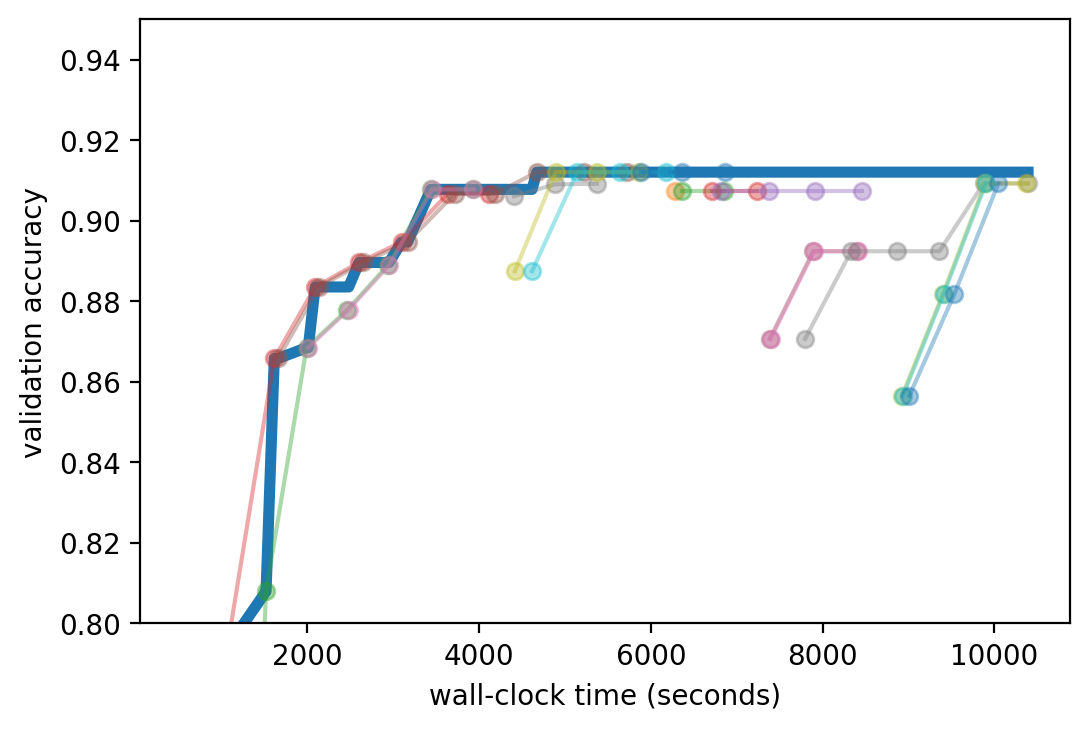

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

from sagemaker_tune.experiments import load_experiment

plt.figure(dpi=200)
r = load_experiment(tuner.tuner_path)
df = r.results
plt.plot(df['smt_tuner_time'], df['accuracy'].cummax(), linewidth=4)

for trial_id in df.trial_id.unique():
    sub_df = df[df['trial_id'] == trial_id]
    y = sub_df['accuracy'].cummax()
    rt =sub_df['smt_tuner_time']    
    plt.plot(rt, y, marker='o', alpha=0.4)

plt.ylabel('validation accuracy')
plt.xlabel('wall-clock time (seconds)')
plt.ylim(0.8, 0.95)